# Life history traits model  26  & 27

Taylor Chapter 3  
model to describe age-structured life history traits of understudied Carcharhinid species

Model versions: both comparable to model 16. mixed effects, no habitats. All continuous variables dumped back into 22 because Aaron says removing variables with a small effect size is frequentist garbage.  Model 27 has all covariates except the ones that are harder to find for understudied species: K,linf, amax.  See if can still predict ogives without these. 
Same as models 22 & 23 excpet model specification changed back to teh structure it had in 16

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.csv',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]

In [5]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [28]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(526, 37)

In [29]:
# take out potential problem stocks
out = ['GSH-I-17', 'SPD-I-19']
mdata = mdata[~mdata.Stock_Year.isin(out)]

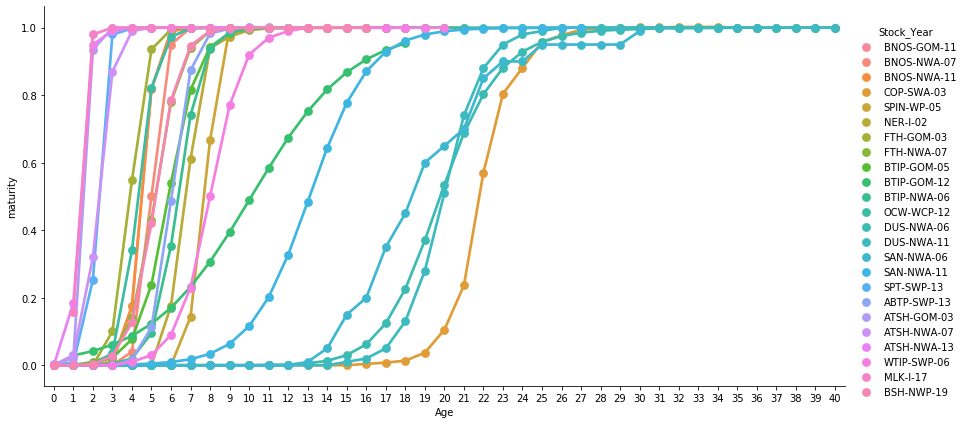

In [30]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [31]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [52]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'COP-SWA-03',
 'SPIN-WP-05',
 'NER-I-02',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'OCW-WCP-12',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPT-SWP-13',
 'ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'WTIP-SWP-06',
 'MLK-I-17',
 'BSH-NWP-19']

In [33]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [34]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

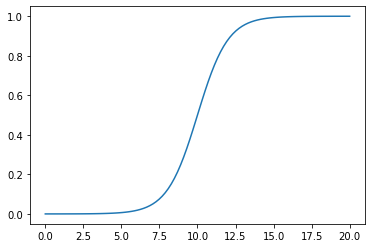

In [12]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

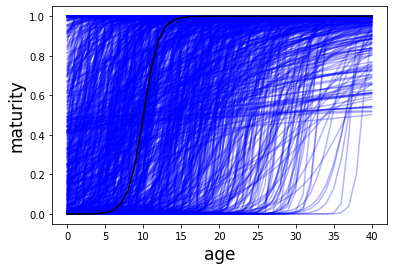

In [13]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('age', fontsize=17)
plt.ylabel('maturity', fontsize=17);

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
#plt.savefig('prior_predictions.jpg');

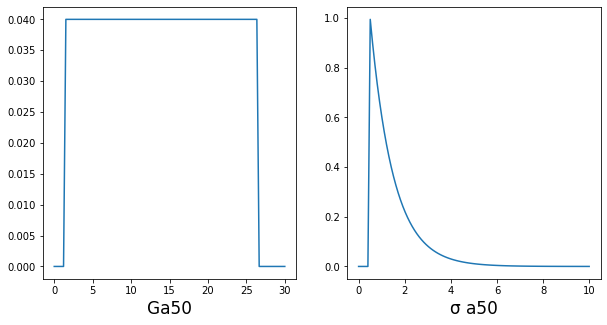

In [14]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 0 and 30
x = np.linspace(0, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

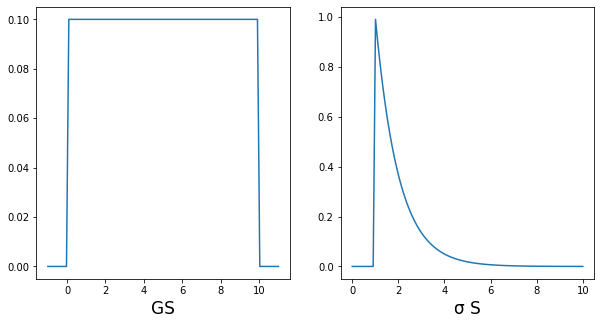

In [15]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [48]:
# random effects model with all covariates
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
 #   B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
 #   B8 = pm.Normal('Litter-S', 0, 3)
 #   B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K +  β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β11*LMAT + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [49]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Temperature, Lmat, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30057 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

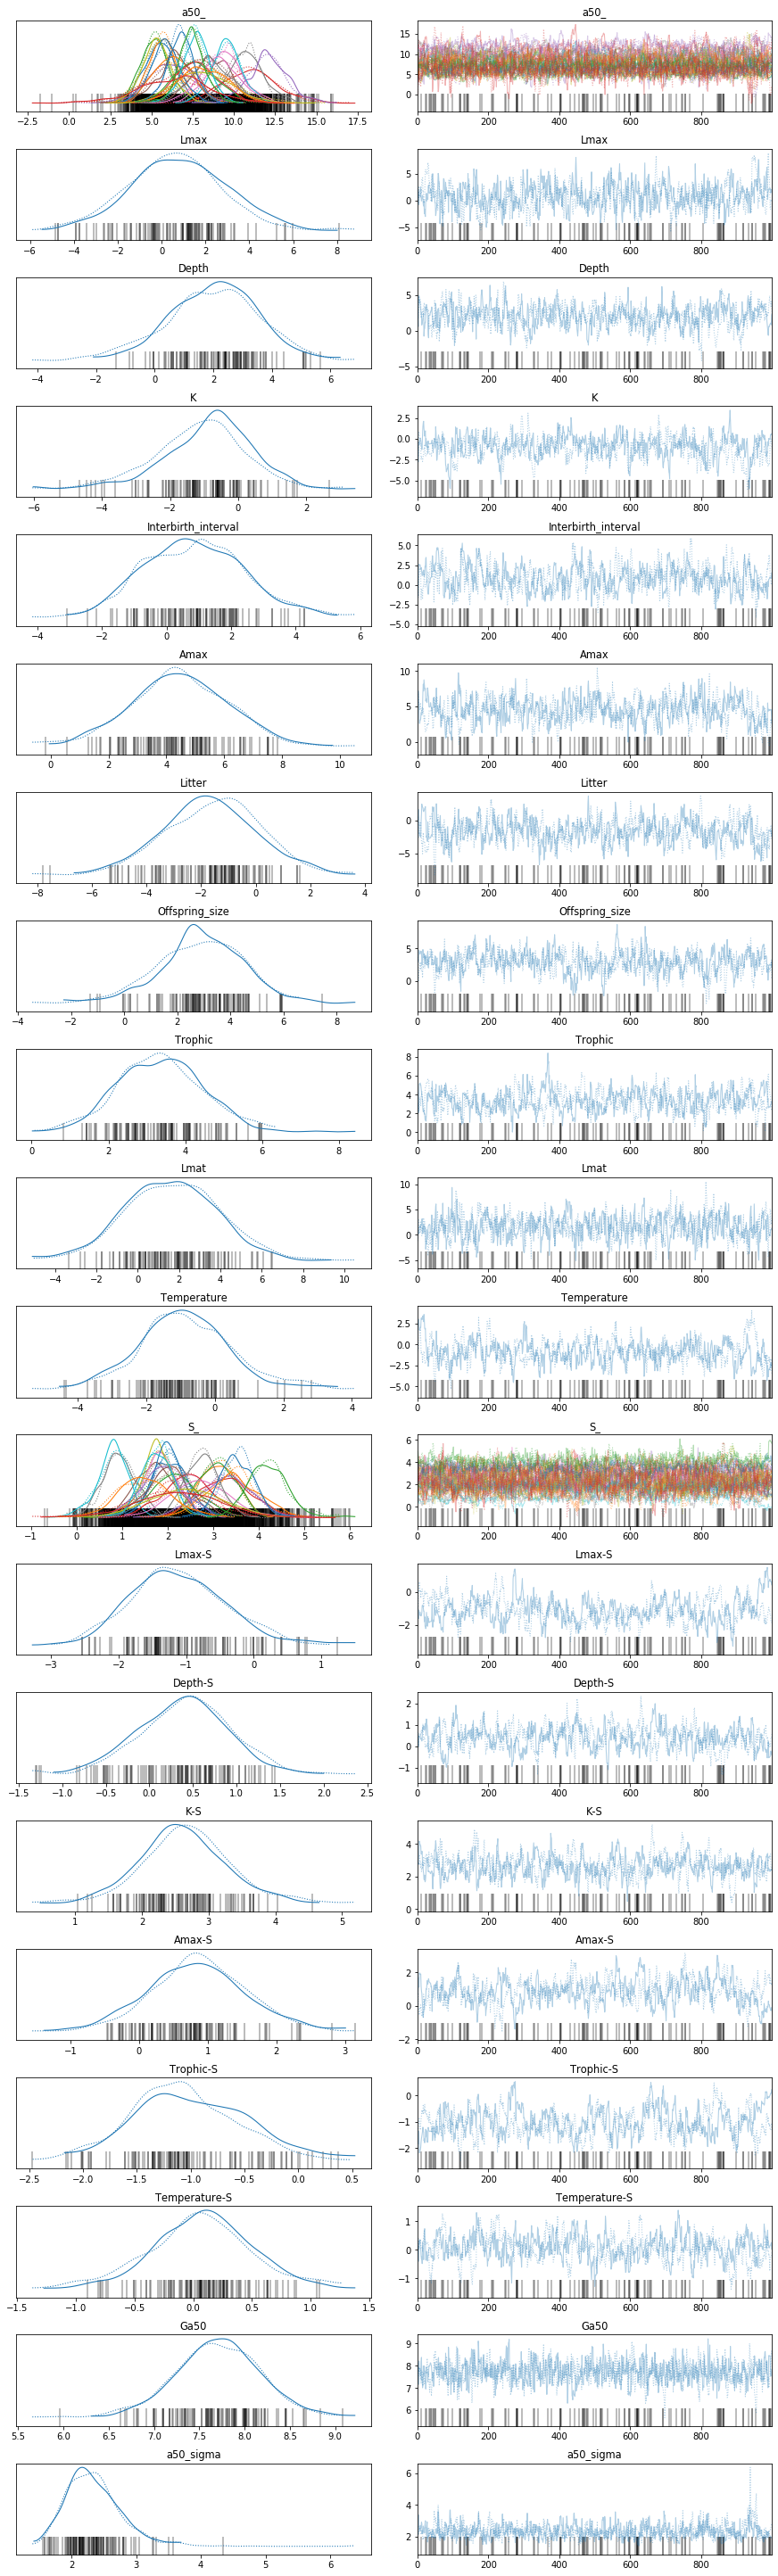

In [50]:
#check model performance
pm.traceplot(trace1);

In [51]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging
# value of 1.4 is too high

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50_[0]    5.579  0.902   3.901    7.121      0.079    0.058     130.0   
a50_[1]    5.676  0.873   4.025    7.324      0.067    0.049     169.0   
a50_[2]    5.180  0.873   3.549    6.836      0.067    0.049     169.0   
a50_[3]   11.044  1.668   7.941   14.251      0.100    0.072     278.0   
a50_[4]    6.084  1.529   3.430    9.259      0.088    0.063     300.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[20]   4.424  0.188   4.091    4.785      0.004    0.003    2091.0   
mu_S[21]   1.196  0.022   1.153    1.234      0.000    0.000    1929.0   
mu_S[22]   5.429  0.377   4.785    6.135      0.016    0.012     570.0   
mu_S[23]   1.616  0.036   1.548    1.685      0.001    0.001    2060.0   
S2         0.008  0.000   0.008    0.009      0.000    0.000     746.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50_[0]    120.0     141.0     154.0   1.00  
a50_[1]    160.0     174.0     228.0   1.00  
a50_[2]    160.0     174.0     229.0   1.00  
a50_[3]    272.0     283.0     357.0   1.00  
a50_[4]    300.0     326.0     354.0   1.01  
...          ...       ...       ...    ...  
mu_S[20]  2002.0    2492.0    1014.0   1.00  
mu_S[21]  1929.0    1880.0    1851.0   1.00  
mu_S[22]   529.0     801.0     421.0   1.00  
mu_S[23]  2055.0    2069.0    1273.0   1.00  
S2         746.0     726.0     646.0   1.00  

[117 rows x 11 columns]

In [46]:
# random effects model with some covs removed
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 0, 30) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
#    β4 = pm.Normal('K', 0, 3)
#    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
#    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
#    β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
#    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
 #   B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
 #   B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
 #   B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
#    B8 = pm.Normal('Litter-S', 0, 3)
#   B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
#    B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP +  β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B7*AMAX  + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [47]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Depth-S, Lmax-S, S_, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Depth, Lmax, a50_, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30464 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


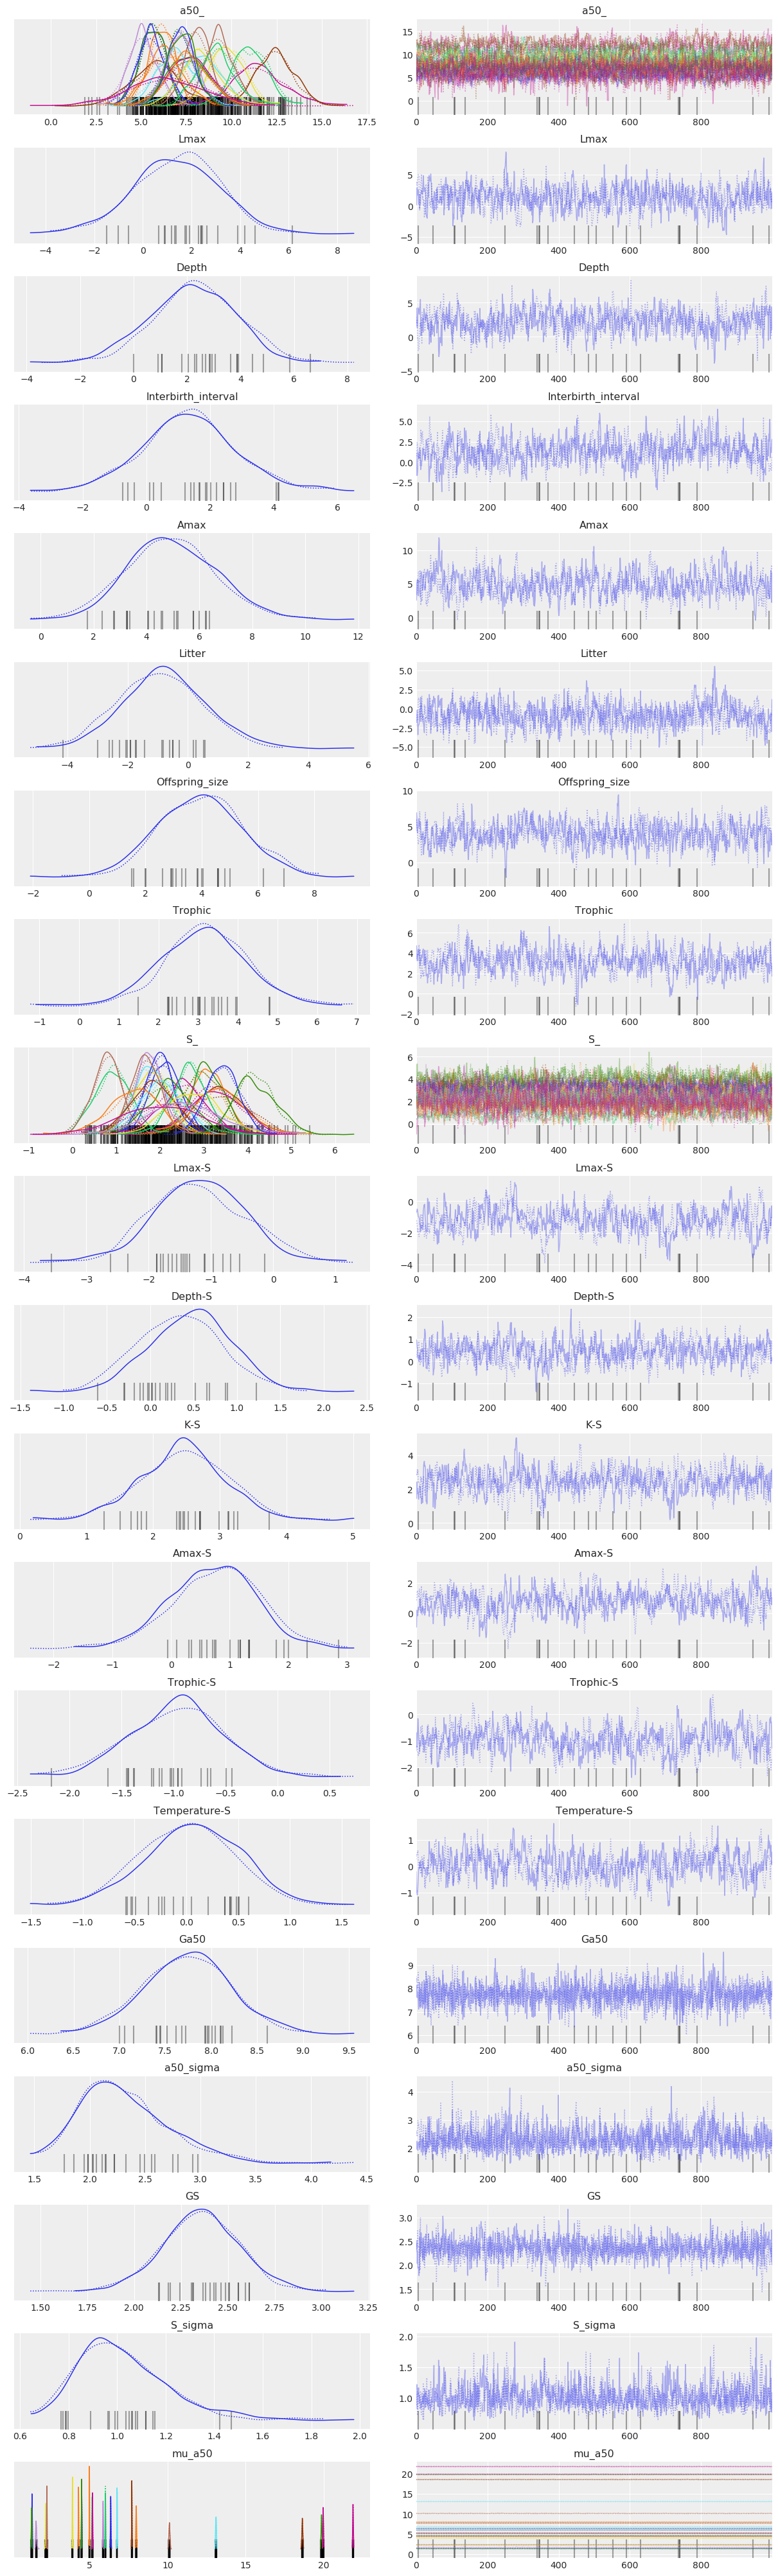

In [60]:
#check model performance
pm.traceplot(trace2);

In [59]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50_[0]    5.629  0.731   4.211    6.926      0.052    0.037     198.0   
a50_[1]    6.125  0.730   4.669    7.380      0.052    0.037     199.0   
a50_[2]    5.629  0.731   4.215    6.934      0.052    0.037     198.0   
a50_[3]   11.439  1.528   8.573   14.409      0.074    0.052     431.0   
a50_[4]    5.853  1.421   3.342    8.662      0.061    0.043     542.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[20]   4.422  0.188   4.053    4.762      0.004    0.003    2876.0   
mu_S[21]   1.197  0.023   1.156    1.242      0.001    0.000    1968.0   
mu_S[22]   5.430  0.379   4.788    6.163      0.009    0.007    1679.0   
mu_S[23]   1.617  0.037   1.550    1.684      0.001    0.001    1909.0   
S2         0.008  0.000   0.008    0.009      0.000    0.000    1748.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50_[0]    198.0     201.0     426.0   1.01  
a50_[1]    199.0     203.0     359.0   1.01  
a50_[2]    198.0     202.0     377.0   1.01  
a50_[3]    431.0     434.0     630.0   1.00  
a50_[4]    542.0     545.0     649.0   1.00  
...          ...       ...       ...    ...  
mu_S[20]  2728.0    2789.0    1252.0   1.00  
mu_S[21]  1968.0    1976.0    1491.0   1.00  
mu_S[22]  1543.0    2435.0     935.0   1.00  
mu_S[23]  1906.0    1914.0    1749.0   1.00  
S2        1748.0    1707.0    1069.0   1.00  

[114 rows x 11 columns]

In [32]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

'.pymc_16.trace'

In [33]:
pm.save_trace(trace2)

'.pymc_17.trace'

### Model Results

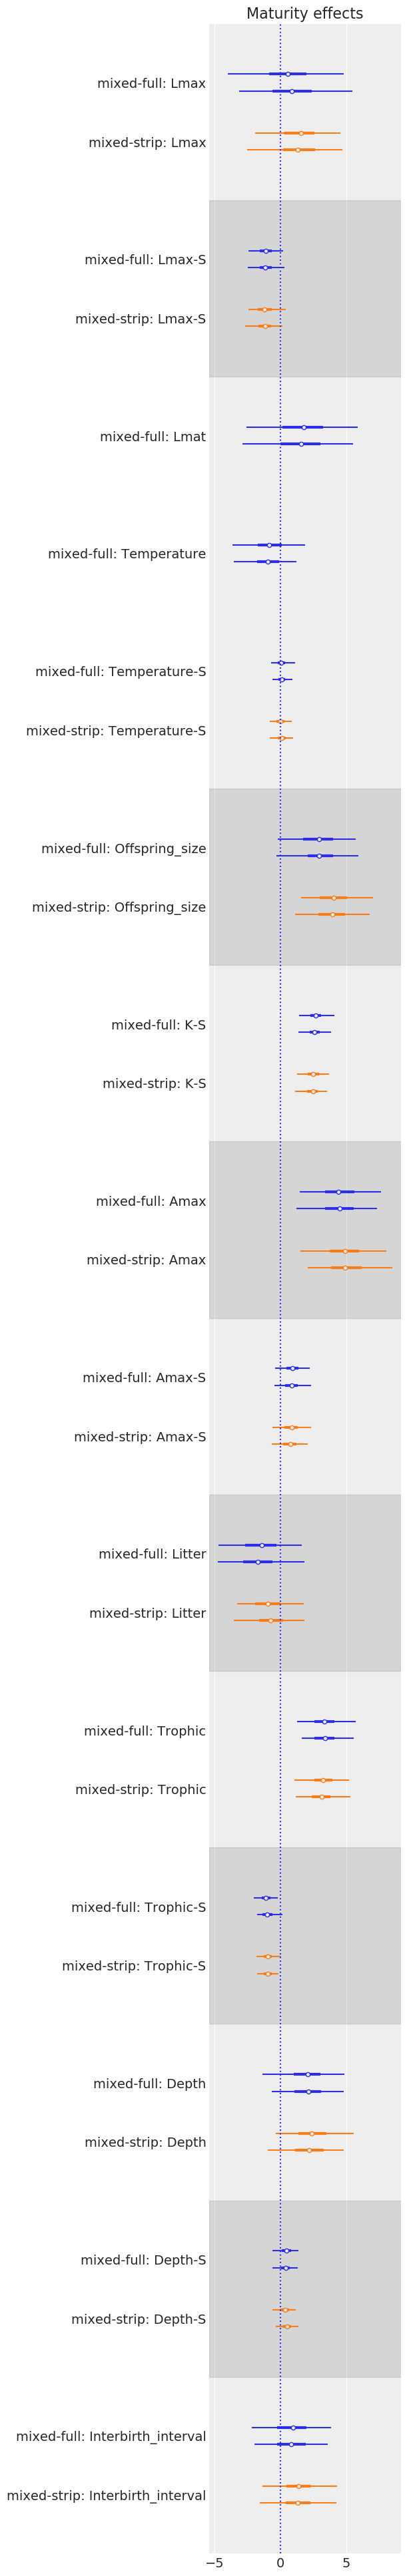

<Figure size 720x480 with 0 Axes>

In [54]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest([trace1, trace2], 
                      model_names=["mixed-full", "mixed-strip"], var_names=["Lmax", "Lmax-S", "Lmat", "Temperature", "Temperature-S", "Offspring_size", "K-S", "Amax", "Amax-S", "Litter",  "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat26&27_forest.jpg');

### Model Comparison

In [55]:
#WAIC for model 1 (26)
pm.waic(trace1, scale='deviance')

Computed from 2000 by 510 log-likelihood matrix

              Estimate       SE
deviance_waic -3322.01   128.42
p_waic           93.46        -

There has been a warning during the calculation. Please check the results.

In [56]:
#WAIC for model 2 (27)
pm.waic(trace2, scale='deviance')

Computed from 2000 by 510 log-likelihood matrix

              Estimate       SE
deviance_waic -3325.03   127.68
p_waic           91.13        -

There has been a warning during the calculation. Please check the results.

Model 2 slightly better than model 1


#### Look for 'bad' datapoints

In [57]:
loo1 = pm.loo(trace1, mat1)
loo1

Computed from 2000 by 510 log-likelihood matrix

         Estimate       SE
elpd_loo  1651.33    63.99
p_loo      103.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      460   90.2%
 (0.5, 0.7]   (ok)         21    4.1%
   (0.7, 1]   (bad)        20    3.9%
   (1, Inf)   (very bad)    9    1.8%

In [58]:
loo2 = pm.loo(trace2, mat2)
loo2

Computed from 2000 by 510 log-likelihood matrix

         Estimate       SE
elpd_loo  1654.13    63.93
p_loo       99.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      459   90.0%
 (0.5, 0.7]   (ok)         25    4.9%
   (0.7, 1]   (bad)        16    3.1%
   (1, Inf)   (very bad)   10    2.0%

In [61]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]

In [62]:
badpoints1 = mdata.iloc[loo1.pareto_k.values > 0.7]

### Plot model fits

In [63]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
# Skip this step - seems unecessary & causes glitches
#colnames = np.array(list(result1.columns), dtype=object)

#colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat26_model_results.csv')
result1.head()

a50___0   a50___1   a50___2    a50___3   a50___4   a50___5    a50___6  \
0  5.942216  5.802566  5.327540  11.649543  4.844281  8.409387  10.638094   
1  7.812350  7.531269  7.036967  11.297030  2.893385  9.332198  12.088487   
2  7.755213  7.499031  7.010483  11.454818  3.289097  9.167927  12.083275   
3  7.610619  7.004697  6.495557  11.283302  3.136244  8.608578  12.185816   
4  7.232159  7.545085  7.070142  12.449203  5.181929  8.409963  11.988027   

     a50___7   a50___8    a50___9  ...  mu_S__15  mu_S__16  mu_S__17  \
0  11.887444  5.471872   9.757500  ...  0.676299  4.670024  1.901026   
1  13.346829  5.372728   9.590159  ...  0.670425  5.329179  2.086062   
2  13.364705  5.352896   9.628097  ...  0.668994  5.164725  2.026000   
3  13.445007  5.493942   9.816643  ...  0.668413  5.405870  2.042802   
4  13.240029  5.862581  10.082903  ...  0.676730  5.296341  1.939767   

   mu_S__18  mu_S__19  mu_S__20  mu_S__21  mu_S__22  mu_S__23        S2  
0  6.876534  2.762626  4.219415  1.186538  5.236451  1.570382  0.008600  
1  6.943280  2.718394  4.636018  1.158267  6.081651  1.601744  0.008296  
2  6.876058  2.704892  4.622361  1.156986  6.055390  1.626506  0.008261  
3  6.332584  2.615535  4.148294  1.220525  5.645404  1.576685  0.008331  
4  6.679221  2.672872  4.545570  1.169826  4.930494  1.578347  0.008522  

[5 rows x 117 columns]

In [64]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat27_model_results.csv')

In [69]:
result1.columns[5:100]

Index(['a50___5', 'a50___6', 'a50___7', 'a50___8', 'a50___9', 'a50___10',
       'a50___11', 'a50___12', 'a50___13', 'a50___14', 'a50___15', 'a50___16',
       'a50___17', 'a50___18', 'a50___19', 'a50___20', 'a50___21', 'a50___22',
       'a50___23', 'Lmax', 'Depth', 'K', 'Interbirth_interval', 'Amax',
       'Litter', 'Offspring_size', 'Trophic', 'Lmat', 'Temperature', 'S___0',
       'S___1', 'S___2', 'S___3', 'S___4', 'S___5', 'S___6', 'S___7', 'S___8',
       'S___9', 'S___10', 'S___11', 'S___12', 'S___13', 'S___14', 'S___15',
       'S___16', 'S___17', 'S___18', 'S___19', 'S___20', 'S___21', 'S___22',
       'S___23', 'Lmax-S', 'Depth-S', 'K-S', 'Amax-S', 'Trophic-S',
       'Temperature-S', 'Ga50', 'a50_sigma', 'GS', 'S_sigma', 'mu_a50__0',
       'mu_a50__1', 'mu_a50__2', 'mu_a50__3', 'mu_a50__4', 'mu_a50__5',
       'mu_a50__6', 'mu_a50__7', 'mu_a50__8', 'mu_a50__9', 'mu_a50__10',
       'mu_a50__11', 'mu_a50__12', 'mu_a50__13', 'mu_a50__14', 'mu_a50__15',
       'mu_a50__16', 

In [70]:
# Grab data from mat1 results (model 26)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
a50s = np.array([np.median(result1[x]) for x in np.array(['a50___'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['S___'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [46]:
result2.columns

Index(['Lmax', 'Depth', 'Interbirth_interval', 'Litter', 'Offspring_size',
       'Trophic', 'Lmat', 'Temperature', 'Lmax-S', 'Depth-S',
       ...
       'mu_S__17', 'mu_S__18', 'mu_S__19', 'mu_S__20', 'mu_S__21', 'mu_S__22',
       'mu_S__23', 'mu_S__24', 'mu_S__25', 'S2'],
      dtype='object', length=122)

In [71]:
#Grab data from mat2 (model 27 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

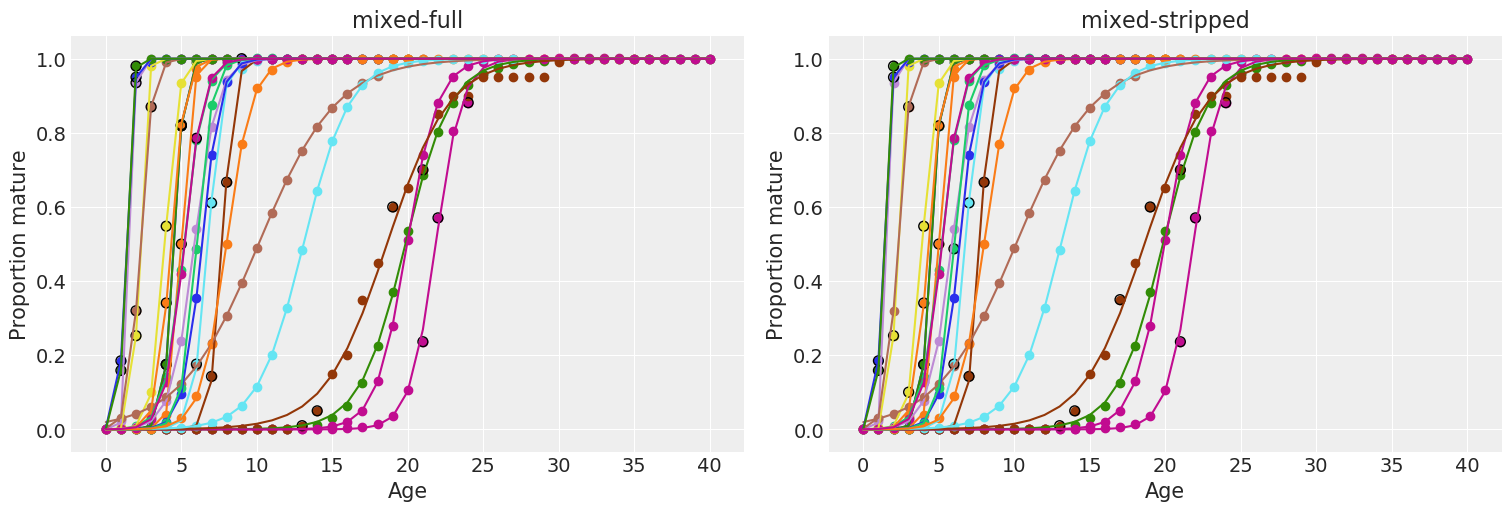

In [72]:
#set up figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
ax_ = axes.flatten()

#Plot mat16
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-full')

#Plot mat17
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('mixed-stripped')

#save results
plt.savefig('mat26_mat27_modelfit.jpg',dpi=300);

NameError: name 'badpoints3' is not defined

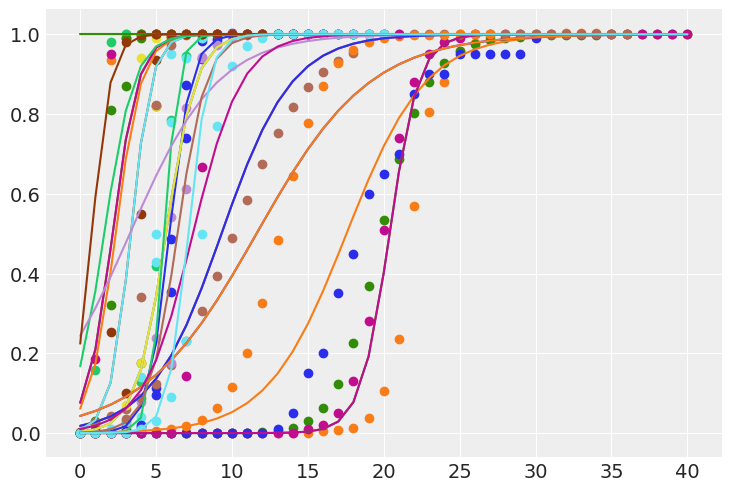

In [49]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
# plot bad datapoints
plt.scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)